### Load data

In [91]:
import pandas as pd
import numpy as np

liver_data = pd.read_csv('../NCDB_2022/liver.csv')

/var/folders/4r/chd7cdjn77j6krd2g7fstr3h0000gn/T/ipykernel_48277/1578868845.py:4: DtypeWarning: Columns (164,170,173,176,177,179,218,219,220,319,320,322,323,331,332,333,334) have mixed types. Specify dtype option on import or set low_memory=False.
  liver_data = pd.read_csv('../NCDB_2022/liver.csv')


### Filter HCC

In [92]:
valid_hist_codes = [8170, 8171, 8172, 8173, 8174, 8175, 8180]

df_hcc = liver_data[liver_data['HISTOLOGY'].isin(valid_hist_codes)]
df_hcc['HISTOLOGY'].unique()

array([8170, 8174, 8180, 8171, 8172, 8173, 8175])

In [93]:
df_hcc.shape

(287919, 340)

### Filter TACE & Systemic

In [94]:
df_hcc = df_hcc[
    df_hcc['RX_SUMM_CHEMO'].isin([2, 3]) &
    df_hcc['DX_IMMUNO_STARTED_DAYS'].notna()
]

df_hcc.shape

(2401, 340)

### Exclude same day

In [95]:
same_day = (df_hcc['DX_CHEMO_STARTED_DAYS'] - df_hcc['DX_IMMUNO_STARTED_DAYS']).abs() < 1e-6
df_hcc[same_day].shape


(532, 340)

In [96]:
df_hcc = df_hcc[df_hcc['DX_CHEMO_STARTED_DAYS'] != df_hcc['DX_IMMUNO_STARTED_DAYS']]
df_hcc.shape

(1869, 340)

### Define Sequence Group

In [97]:
df_hcc['sequence_group'] = df_hcc.apply(
    lambda row: 1 if row['DX_CHEMO_STARTED_DAYS'] < row['DX_IMMUNO_STARTED_DAYS']
    else 0,
    axis=1
)

df_hcc['sequence_group'].value_counts()


sequence_group
1    1423
0     446
Name: count, dtype: int64

### Clean Covariates

#### Combine Stage

In [98]:
df_hcc['COMBINED_STAGE_GROUP'] = df_hcc['AJCC_TNM_CLIN_STG_GRP'].combine_first(
    df_hcc['TNM_PATH_STAGE_GROUP']
)

df_hcc = df_hcc.drop(columns=[
    'AJCC_TNM_CLIN_STG_GRP', 'TNM_PATH_STAGE_GROUP'
])

In [99]:
df_hcc['COMBINED_STAGE_GROUP'].value_counts()

COMBINED_STAGE_GROUP
4B    431
3A    337
99    335
3B    235
2     221
4A    149
1B     93
88     23
1A     21
1       5
3C      4
4       2
3       1
Name: count, dtype: int64

In [100]:
df_hcc['COMBINED_STAGE_GROUP'].isna().sum()

np.int64(12)

In [101]:
df_hcc['COMBINED_STAGE_GROUP'] = df_hcc['COMBINED_STAGE_GROUP'].astype(str).replace({
    '1A': '1', '1B': '1',
    '3A': '3', '3B': '3', '3C': '3',
    '4A': '4', '4B': '4',
})

df_hcc = df_hcc[df_hcc['COMBINED_STAGE_GROUP'].isin(['1', '2', '3', '4'])]

In [102]:
df_hcc['COMBINED_STAGE_GROUP'].value_counts()

COMBINED_STAGE_GROUP
4    582
3    577
2    221
1    119
Name: count, dtype: int64

In [103]:
df_hcc.shape

(1499, 340)

#### Other covariates

In [104]:
covariates = [
    'AGE', 'SEX', 'RACE', 'SPANISH_HISPANIC_ORIGIN', #Demographics
    'INSURANCE_STATUS', 'MED_INC_QUAR_2020', #Socioeconomic
    'CDCC_TOTAL_BEST', 'HISTOLOGY', 'TUMOR_SIZE_SUMMARY_2016', 'COMBINED_STAGE_GROUP', #Clinical
    'FACILITY_TYPE_CD', 'FACILITY_LOCATION_CD', #Facility
    'YEAR_OF_DIAGNOSIS' #Temporal
]

#Recode year of diagnosis
def collapse_year(year):
    if year >= 2020:
        return '2020+'
    elif year >= 2018:
        return '2018–2019'
    else:
        return '≤2017'

df_hcc['YEAR_OF_DIAGNOSIS'] = df_hcc['YEAR_OF_DIAGNOSIS'].apply(collapse_year)


# Recode SEX
df_hcc['SEX'] = df_hcc['SEX'].replace({1: 'Male', 2: 'Female'})

# Recode RACE
df_hcc['RACE'] = df_hcc['RACE'].astype(str).map({
    '01': 'White',
    '02': 'Black',
    '04': 'Asian', '05': 'Asian', '06': 'Asian', '08': 'Asian', '10': 'Asian',
    '11': 'Asian', '12': 'Asian', '13': 'Asian', '14': 'Asian', '15': 'Asian',
    '16': 'Asian', '17': 'Asian', '96': 'Asian',
    '03': 'Pacific Islander', '20': 'Pacific Islander', '21': 'Pacific Islander',
    '22': 'Pacific Islander', '25': 'Pacific Islander', '26': 'Pacific Islander',
    '27': 'Pacific Islander', '28': 'Pacific Islander', '30': 'Pacific Islander',
    '31': 'Pacific Islander', '32': 'Pacific Islander', '97': 'Pacific Islander'
}).fillna('Other')

# Recode INSURANCE_STATUS
df_hcc['INSURANCE_STATUS'] = df_hcc['INSURANCE_STATUS'].map({
    0: 'No insurance',
    1: 'Private/Managed Care',
    2: 'Medicaid',
    3: 'Medicare',
    4: 'Other Government',
    9: 'Unknown'
}).fillna('Unknown')

# Recode area_MedianIncome2016_2020 from MED_INC_QUAR_2020
df_hcc['MEDIAN_INCOME'] = df_hcc['MED_INC_QUAR_2020'].map({
    1: '<$46,277',
    2: '$46,277-$57,856',
    3: '$57,857-$74,062',
    4: '>$74,063'
}).fillna('Unknown')

# Recode Charlson-Deyo Score
df_hcc['Charlson_Deyo_Score'] = df_hcc['CDCC_TOTAL_BEST'].map({
    0: '0',
    1: '1',
    2: '2',
    3: '3'
}).fillna('Unknown')

# Recode area_NoHighSchooldegree2016_2020
# df_hcc['NoHighSchooldegree2016_2020'] = df_hcc['NO_HSD_QUAR_2020'].map({
#     1: '>=15.3%',
#     2: '9.1%-15.2%',
#     3: '5.0%-9.0%',
#     4: '<5.0%'
# }).fillna('Unknown')

# Recode facility type
df_hcc['FACILITY_TYPE'] = df_hcc['FACILITY_TYPE_CD'].map({
    1: 'Community Cancer Program',
    2: 'Comprehensive Community Cancer Program',
    3: 'Academic/Research Program',
    4: 'Integrated Network Cancer Program'
}).fillna('Unknown')

# Recode HISTOLOGY for HCC (your definition)
hcc_hist_map = {
    8170: 'HCC, NOS',
    8171: 'Fibrolamellar HCC',
    8172: 'Scirrhous HCC',
    8173: 'Spindle cell HCC',
    8174: 'Clear cell HCC',
    8175: 'Pleomorphic HCC',
    8180: 'Mixed HCC-Cholangiocarcinoma'
}
df_hcc['HISTOLOGY'] = df_hcc['HISTOLOGY'].map(hcc_hist_map).fillna('Other')

# Recode the region values using map()
region_map = {
    1: "New England",
    2: "Middle Atlantic",
    3: "South Atlantic",
    4: "East North Central",
    5: "East South Central",
    6: "West North Central",
    7: "West South Central",
    8: "Mountain",
    9: "Pacific"
}

df_hcc['FACILITY_REGION'] = df_hcc['FACILITY_LOCATION_CD'].map(region_map).fillna('Unknown')

#Recode hispanic origin
def recode_hispanic_origin(x):
    if x == 0:
        return "Non-Hispanic"
    elif x in [1, 2, 3, 4, 5, 6, 8]:
        return "Hispanic"
    elif x == 7:
        return "Likely Hispanic"
    elif x == 9:
        return "Unknown"
    else:
        return "Unknown"

df_hcc['HISPANIC'] = df_hcc['SPANISH_HISPANIC_ORIGIN'].apply(recode_hispanic_origin)

# Recode tumor size
df_hcc['TUMOR_SIZE_SUMMARY_2016'] = pd.to_numeric(df_hcc['TUMOR_SIZE_SUMMARY_2016'], errors='coerce')
df_hcc.loc[df_hcc['TUMOR_SIZE_SUMMARY_2016'] > 300.0, 'TUMOR_SIZE_SUMMARY_2016'] = np.nan

def bin_tumor_size(x):
    if pd.isna(x):
        return 'Unknown'
    elif x == 0:
        return 'No tumor'
    elif x <= 30:
        return '≤3 cm'
    elif x <= 50:
        return '3–5 cm'
    elif x <= 100:
        return '5–10 cm'
    elif x <= 200:
        return '10–20 cm'
    else:
        return '>20 cm'
    
df_hcc['TUMOR_SIZE'] = df_hcc['TUMOR_SIZE_SUMMARY_2016'].apply(bin_tumor_size)

In [105]:
columns_to_drop = [
    'SPANISH_HISPANIC_ORIGIN',
    'MED_INC_QUAR_2020',
    'CDCC_TOTAL_BEST',
    'TUMOR_SIZE_SUMMARY_2016',
    'FACILITY_TYPE_CD',
    'FACILITY_LOCATION_CD'
]

df_hcc = df_hcc.drop(columns=columns_to_drop)

covariates = [
    'AGE', 'SEX', 'RACE', 'HISPANIC', #Demographics
    'INSURANCE_STATUS', 'MEDIAN_INCOME', #Socioeconomic
    'Charlson_Deyo_Score', 'HISTOLOGY', 'TUMOR_SIZE', 'COMBINED_STAGE_GROUP', #Clinical
    'FACILITY_TYPE', 'FACILITY_REGION', #Facility
    'YEAR_OF_DIAGNOSIS' #Temporal
]

### Propensity score

In [106]:
from sklearn.linear_model import LogisticRegression

# One-hot encode categorical covariates
df_encoded = pd.get_dummies(df_hcc[covariates], drop_first=True)
X = df_encoded
y = df_hcc['sequence_group']

ps_model = LogisticRegression(max_iter=2000)
ps_model.fit(X, y)

df_hcc['ps'] = ps_model.predict_proba(X)[:, 1]


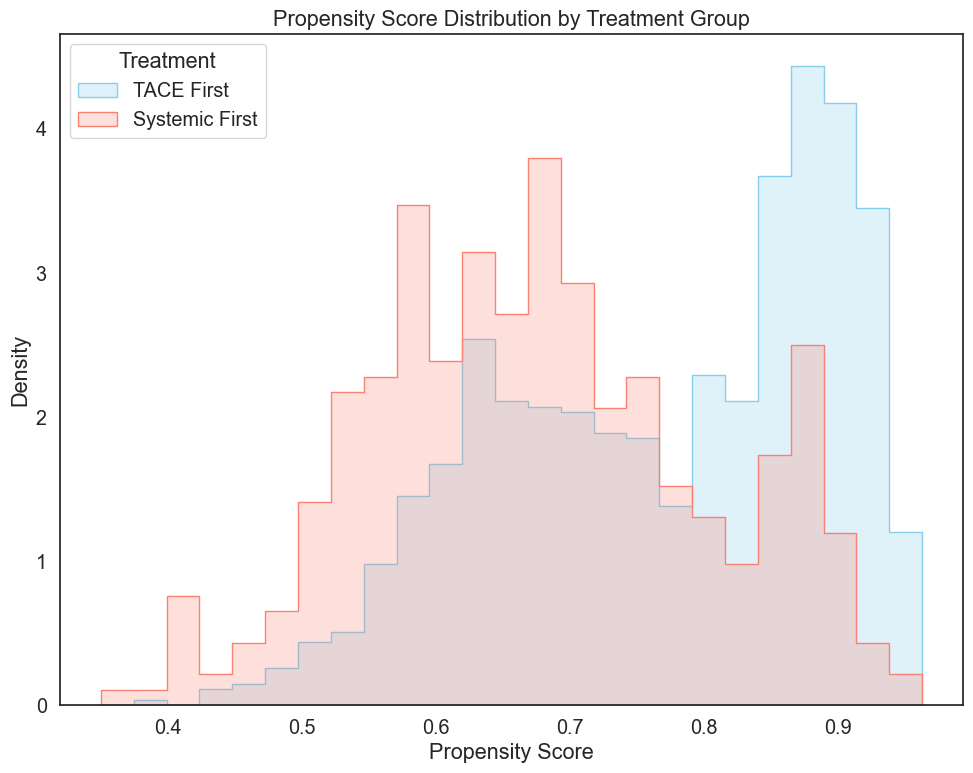

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(
    data=df_hcc,
    x='ps',
    hue='sequence_group',
    bins=25,
    element="step",
    stat="density",
    common_norm=False,
    palette={0: "salmon", 1: "skyblue"}
)

plt.title("Propensity Score Distribution by Treatment Group")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend(title="Treatment", labels=["TACE First", "Systemic First"])
plt.tight_layout()
plt.show()

## IPTW

### IPTW weights

In [108]:
df_hcc['iptw_weight'] = df_hcc.apply(
    lambda row: 1 / row['ps'] if row['sequence_group'] == 1 else 1 / (1 - row['ps']),
    axis=1
)
df_hcc['iptw_weight'].describe()

count    1499.000000
mean        1.977953
std         1.685373
min         1.038942
25%         1.158393
50%         1.414484
75%         1.984324
max        21.436287
Name: iptw_weight, dtype: float64

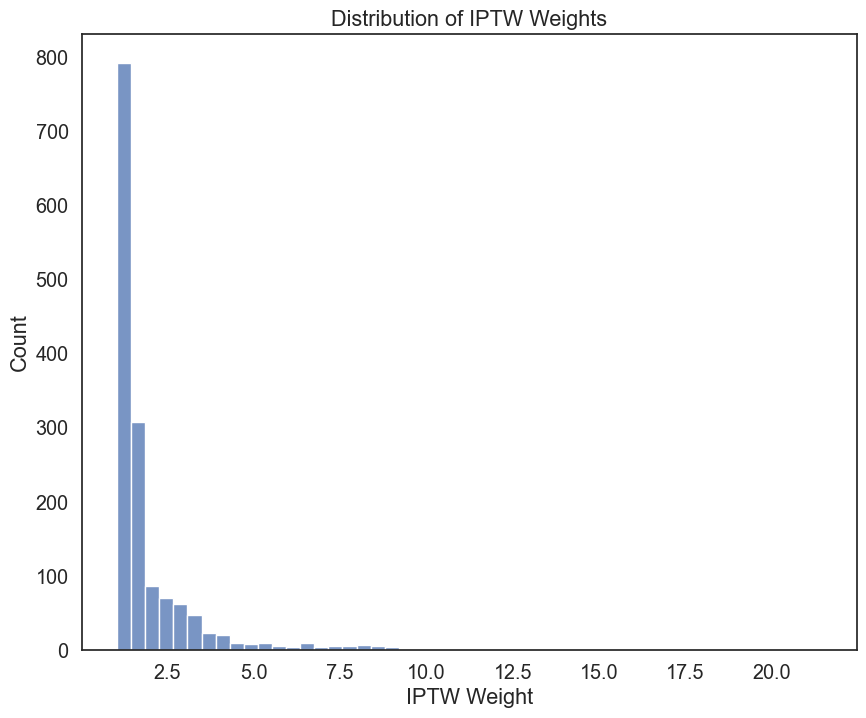

In [109]:
sns.histplot(df_hcc['iptw_weight'], bins=50)
plt.title("Distribution of IPTW Weights")
plt.xlabel("IPTW Weight")
plt.ylabel("Count")
plt.show()

### ITPW ASMD

In [110]:
def compute_asmd(df, covariate, treatment_col, weight_col=None):
    groups = df[treatment_col].unique()
    g1 = df[df[treatment_col] == groups[0]]
    g2 = df[df[treatment_col] == groups[1]]

    if weight_col is None:
        w1 = np.ones(len(g1))
        w2 = np.ones(len(g2))
    else:
        w1 = g1[weight_col].values
        w2 = g2[weight_col].values

    def weighted_mean_std(x, w):
        mean = np.average(x, weights=w)
        var = np.average((x - mean)**2, weights=w)
        return mean, np.sqrt(var)

    if df[covariate].dtype in [np.float64, np.int64]:
        m1, s1 = weighted_mean_std(g1[covariate], w1)
        m2, s2 = weighted_mean_std(g2[covariate], w2)
        pooled_sd = np.sqrt((s1**2 + s2**2)/2)
        asmd = abs(m1 - m2) / pooled_sd
    else:
        # Categorical variable: use dummy encoding
        dummies = pd.get_dummies(df[covariate], drop_first=False)
        asmd_list = []
        for level in dummies.columns:
            x1 = dummies.loc[g1.index, level]
            x2 = dummies.loc[g2.index, level]
            m1 = np.average(x1, weights=w1)
            m2 = np.average(x2, weights=w2)
            pooled = (m1*(1 - m1) + m2*(1 - m2)) / 2
            asmd = abs(m1 - m2) / np.sqrt(pooled) if pooled > 0 else 0
            asmd_list.append(asmd)
        asmd = np.mean(asmd_list)
    return asmd


In [111]:
asmd_unweighted = []
asmd_weighted = []

for covariate in covariates:
    try:
        a1 = compute_asmd(df_hcc, covariate, 'sequence_group', weight_col=None)
        a2 = compute_asmd(df_hcc, covariate, 'sequence_group', weight_col='iptw_weight')
    except Exception as e:
        print(f"Skipping {covariate}: {e}")
        continue
    asmd_unweighted.append(a1)
    asmd_weighted.append(a2)

asmd_df = pd.DataFrame({
    'Covariate': covariates,
    'Unweighted': asmd_unweighted,
    'IPTW': asmd_weighted
})


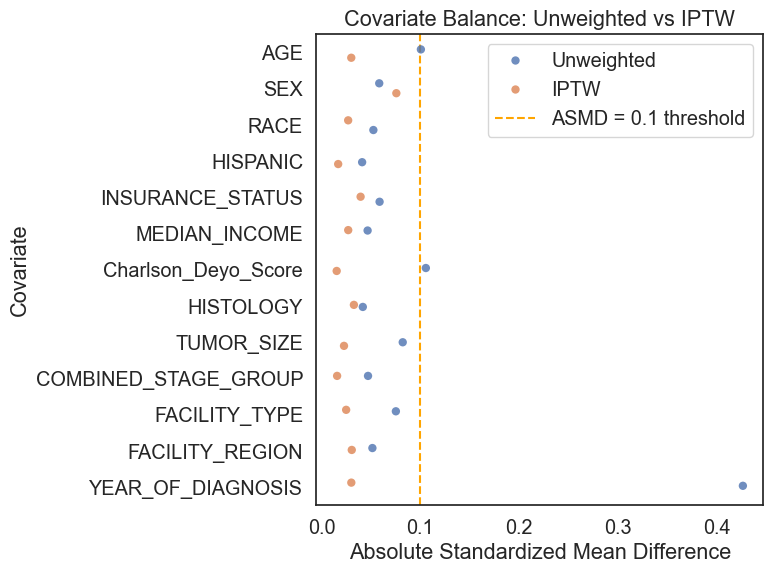

In [112]:
asmd_df_melted = asmd_df.melt(id_vars='Covariate', var_name='Method', value_name='ASMD')

plt.figure(figsize=(8, 6))
sns.stripplot(data=asmd_df_melted, x='ASMD', y='Covariate', hue='Method', jitter=0.15, size=6, alpha=0.8)
plt.axvline(0.1, linestyle='--', color='orange', label='ASMD = 0.1 threshold')
plt.xlabel("Absolute Standardized Mean Difference")
plt.title("Covariate Balance: Unweighted vs IPTW")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### IPTW-weighted Kaplan-Meier and Cox

#### KM

In [113]:
# Keep only valid cases
df_surv = df_hcc.copy()

# Drop missing or invalid values
df_surv = df_surv[
    (df_surv['PUF_VITAL_STATUS'].isin([0, 1])) &
    (df_surv['DX_LASTCONTACT_DEATH_MONTHS'].notna()) &
    (df_surv['DX_LASTCONTACT_DEATH_MONTHS'] != 9999.0)
].copy()

# Create survival time and event indicators
df_surv['time'] = df_surv['DX_LASTCONTACT_DEATH_MONTHS']
df_surv['event'] = df_surv['PUF_VITAL_STATUS'].apply(lambda x: 1 if x == 0 else 0)  # 1 = dead = event

# Confirm format
df_surv.shape

(1245, 343)

In [114]:
df_surv['group_label'] = df_surv['sequence_group'].map({0: 'Systemic First', 1: 'TACE First'})

In [115]:
from lifelines import KaplanMeierFitter

# Split into TACE-first and Systemic-first
mask_tace = df_surv['sequence_group'] == 1
mask_sys = df_surv['sequence_group'] == 0

# Initialize fitters
kmf_tace = KaplanMeierFitter()
kmf_sys = KaplanMeierFitter()

# Fit each group with weights
kmf_tace.fit(
    durations=df_surv.loc[mask_tace, 'time'],
    event_observed=df_surv.loc[mask_tace, 'event'],
    weights=df_surv.loc[mask_tace, 'iptw_weight'],
    label="TACE First"
)

kmf_sys.fit(
    durations=df_surv.loc[mask_sys, 'time'],
    event_observed=df_surv.loc[mask_sys, 'event'],
    weights=df_surv.loc[mask_sys, 'iptw_weight'],
    label="Systemic First"
)

/Users/nicolaszhang/miniconda3/envs/data_science_env/lib/python3.12/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  warnings.warn(
/Users/nicolaszhang/miniconda3/envs/data_science_env/lib/python3.12/site-packages/lifelines/fitters/kaplan_meier_fitter.py:338: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate

<lifelines.KaplanMeierFitter:"Systemic First", fitted with 1142.86 total observations, 400.999 right-censored observations>

#### Weighted Number at Risk

In [116]:
time_grid = np.arange(0, df_surv['time'].max(), 12)  # 0, 12, 24, ..., up to max observed time

def weighted_risk_counts(df, time_points, group_value):
    risk_counts = []
    group = df[df['sequence_group'] == group_value]
    for t in time_points:
        still_at_risk = group[group['time'] >= t]['iptw_weight'].sum()
        risk_counts.append(int(round(still_at_risk)))
    return risk_counts

tace_risk = weighted_risk_counts(df_surv, time_grid, 1)
sys_risk = weighted_risk_counts(df_surv, time_grid, 0)



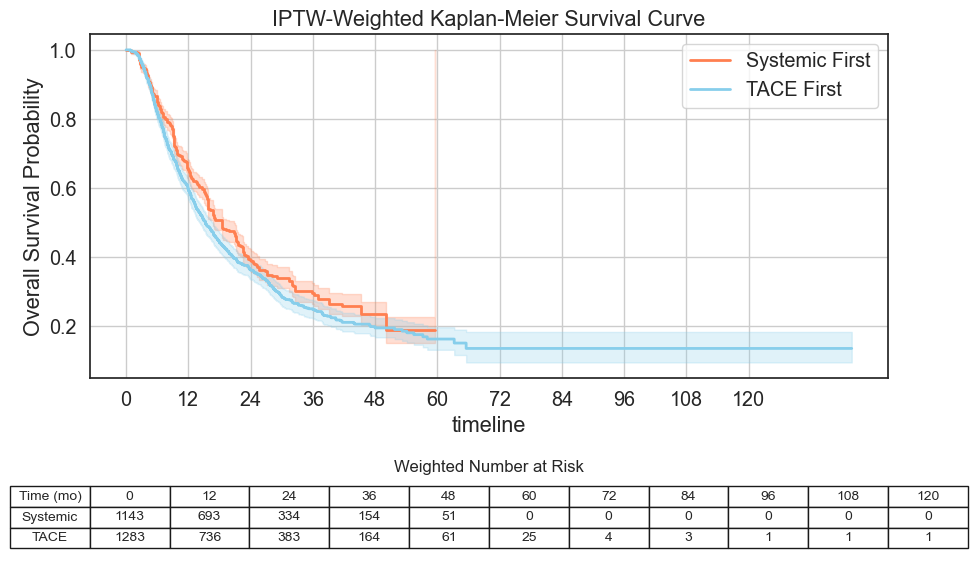

In [117]:
from matplotlib import gridspec
from matplotlib.table import Table

time_grid = np.arange(0, 121, 12)

# Build the plot
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 0.8])

# Top: KM plot
ax_km = plt.subplot(gs[0])
kmf_sys.plot(ax=ax_km, ci_show=True, color="coral", linewidth=2)
kmf_tace.plot(ax=ax_km, ci_show=True, color="skyblue", linewidth=2)

ax_km.set_title("IPTW-Weighted Kaplan-Meier Survival Curve")
ax_km.set_ylabel("Overall Survival Probability")
ax_km.set_xticks(time_grid)  # Align x-ticks with table
ax_km.grid(True)

# Bottom: risk table
ax_table = plt.subplot(gs[1])
ax_table.axis("off")

# Table data
n_cols = len(time_grid)
table_data = [
    ["Time (mo)"] + [str(int(t)) for t in time_grid],
    ["Systemic"] + [str(n) for n in sys_risk[:n_cols]],
    ["TACE"] + [str(n) for n in tace_risk[:n_cols]]
]

# Create table
risk_table = ax_table.table(
    cellText=table_data,
    cellLoc='center',
    loc='center'
)
ax_table.text(0.5, 1, "Weighted Number at Risk", fontsize=12,
              ha='center', transform=ax_table.transAxes)

risk_table.auto_set_font_size(False)
risk_table.set_fontsize(10)
risk_table.scale(1.2, 1.2)

plt.tight_layout()
plt.show()

"Kaplan-Meier estimates were weighted using IPTW. Variance estimates were not corrected via bootstrap or Monte Carlo methods."

#### Cox

In [118]:
from lifelines import CoxPHFitter

df_cox = df_surv[['time', 'event', 'sequence_group', 'iptw_weight']].copy()

cph = CoxPHFitter()
cph.fit(df_cox, duration_col='time', event_col='event', weights_col='iptw_weight', robust=True)
cph.print_summary()



<lifelines.CoxPHFitter: fitted with 2425.92 total observations, 761.727 right-censored observations>
             duration col = 'time'
                event col = 'event'
              weights col = 'iptw_weight'
          robust variance = True
      baseline estimation = breslow
   number of observations = 2425.92
number of events observed = 1664.2
   partial log-likelihood = -11854.74
         time fit was run = 2025-05-22 21:56:53 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
sequence_group  0.13      1.14      0.10           -0.06            0.33                0.94                1.38

                cmp to    z    p  -log2(p)
covariate                                 
sequence_group    0.00 1.34 0.18      2.48
---
Concordance = 0.52
Partial AIC = 23711.48
log-likelihood ratio test = 7.19 on 1 df
-log2(p) of ll-ratio test = 7.09

### 3 & 5 year survival

In [119]:
def survival_with_ci(kmf, time):
    surv = kmf.predict(time)
    
    closest_idx = kmf.confidence_interval_.index.get_indexer([time], method='nearest')[0]
    ci = kmf.confidence_interval_.iloc[closest_idx]

    lower = ci.iloc[0]
    upper = ci.iloc[1]

    # sanity check for CI
    if (upper == 1.0 and lower == 1.0) or (upper == 0.0 and lower == 0.0):
        return surv, None, None  # invalid or non-estimable CI

    return surv, lower, upper

for t in [36, 60]:
    surv_sys, low_sys, high_sys = survival_with_ci(kmf_sys, t)
    surv_tace, low_tace, high_tace = survival_with_ci(kmf_tace, t)


    print(f"\nTime: {t} months")
    print(f"TACE First:     {surv_tace:.1%} ({low_tace:.1%} – {high_tace:.1%})")
    
    if low_sys is None:
        print(f"Systemic First: {surv_sys:.1%} (CI not estimable)")
    else:
        print(f"Systemic First: {surv_sys:.1%} ({low_sys:.1%} – {high_sys:.1%})")





Time: 36 months
TACE First:     24.8% (22.2% – 27.5%)
Systemic First: 29.5% (25.8% – 32.0%)

Time: 60 months
TACE First:     16.3% (13.2% – 19.7%)
Systemic First: 18.8% (CI not estimable)


### Combined Plot

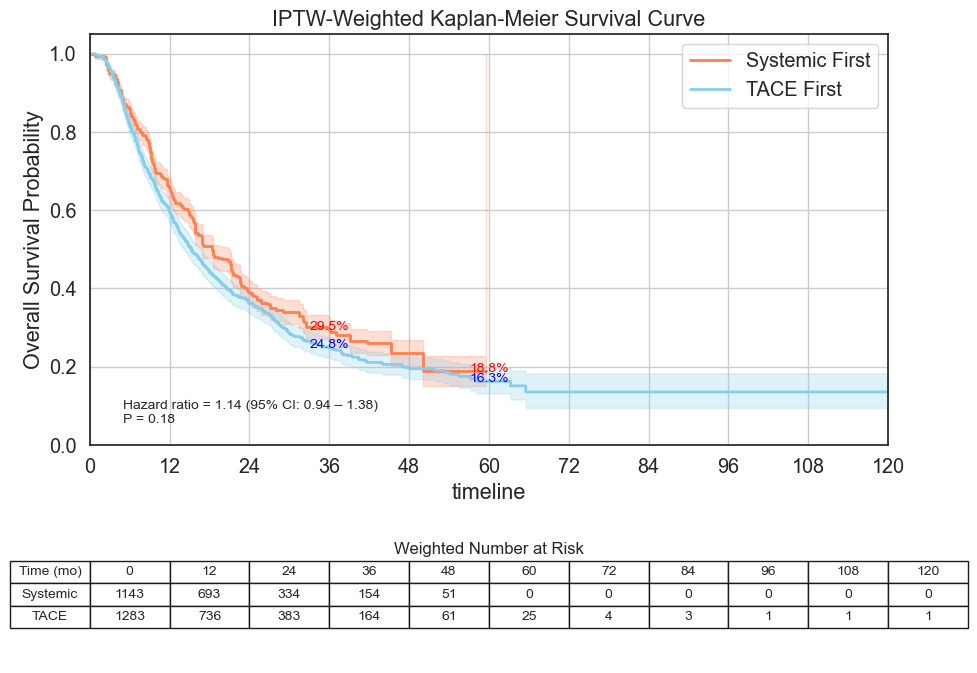

In [120]:
# Time points and weighted number at risk (replace with your actual IPTW-weighted values)
time_grid = np.arange(0, 121, 12)
sys_risk = [1143, 693, 334, 154, 51, 0, 0, 0, 0, 0, 0]
tace_risk = [1283, 736, 383, 164, 61, 25, 4, 3, 1, 1, 1]

# 3-year and 5-year survival annotations
surv_text = {
    "Systemic First": {
        36: "29.5%",
        60: "18.8%"
    },
    "TACE First": {
        36: "24.8%",
        60: "16.3%"
    }
}

# Cox model results
hr = 1.14
ci_low = 0.94
ci_high = 1.38
p_val = 0.18

# Set up the plot
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# --- KM Curve (Top Panel) ---
ax_km = plt.subplot(gs[0])

# Simulated curves (replace with kmf.plot output in actual use)
months = np.linspace(0, 120, 121)
kmf_sys.plot(ax=ax_km, ci_show=True, color="coral", linewidth=2)
kmf_tace.plot(ax=ax_km, ci_show=True, color="skyblue", linewidth=2)

sys_surv = kmf_sys.predict(months)
tace_surv = kmf_tace.predict(months)

# Annotate survival rates at 3 and 5 years
for x in [36, 60]:
    ax_km.text(x, sys_surv[x], surv_text["Systemic First"][x], color="red", fontsize=10, ha='center')
    ax_km.text(x, tace_surv[x], surv_text["TACE First"][x], color="blue", fontsize=10, ha='center')

# Annotate Cox HR and p-value
hr_text = f"Hazard ratio = {hr:.2f} (95% CI: {ci_low:.2f} – {ci_high:.2f})\nP = {p_val:.2f}"
ax_km.text(5, 0.05, hr_text, fontsize=10, verticalalignment='bottom')

# Style the plot
ax_km.set_title("IPTW-Weighted Kaplan-Meier Survival Curve")
ax_km.set_ylabel("Overall Survival Probability")
ax_km.set_xlim(0, 120)
ax_km.set_ylim(0, 1.05)
ax_km.set_xticks(time_grid)
ax_km.grid(True)
ax_km.legend()

# --- Risk Table (Bottom Panel) ---
ax_table = plt.subplot(gs[1])
ax_table.axis("off")

# Table values
table_data = [
    ["Time (mo)"] + [str(int(t)) for t in time_grid],
    ["Systemic"] + [str(n) for n in sys_risk],
    ["TACE"] + [str(n) for n in tace_risk]
]

# Render the table
risk_table = ax_table.table(
    cellText=table_data,
    cellLoc='center',
    loc='center'
)
ax_table.text(0.5, 0.8, "Weighted Number at Risk", fontsize=12,
              ha='center', transform=ax_table.transAxes)
risk_table.auto_set_font_size(False)
risk_table.set_fontsize(10)
risk_table.scale(1.2, 1.2)

plt.tight_layout()
plt.show()


## PSM

In [121]:
from psmpy import PsmPy
from psmpy.functions import cohenD
psm_df = df_surv[['sequence_group'] + covariates + ['time', 'event']].dropna()
psm_df.shape

(1245, 16)

In [123]:
psm_df = psm_df.reset_index().rename(columns={'index': 'id'})
psm_df = pd.get_dummies(psm_df, drop_first=True)
psm = PsmPy(psm_df, treatment='sequence_group', indx='id', exclude=['time', 'event'])

# Calculate PS and match
psm.logistic_ps(balance=True)  # internally fits the logistic regression
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=0.2)


/Users/nicolaszhang/miniconda3/envs/data_science_env/lib/python3.12/site-packages/psmpy/psmpy.py:363: UserWarning: Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False
  warnings.warn('Some values do not have a match. These are dropped for purposes of establishing a matched dataframe, and subsequent calculations and plots (effect size). If you do not wish this to be the case please set drop_unmatched=False')


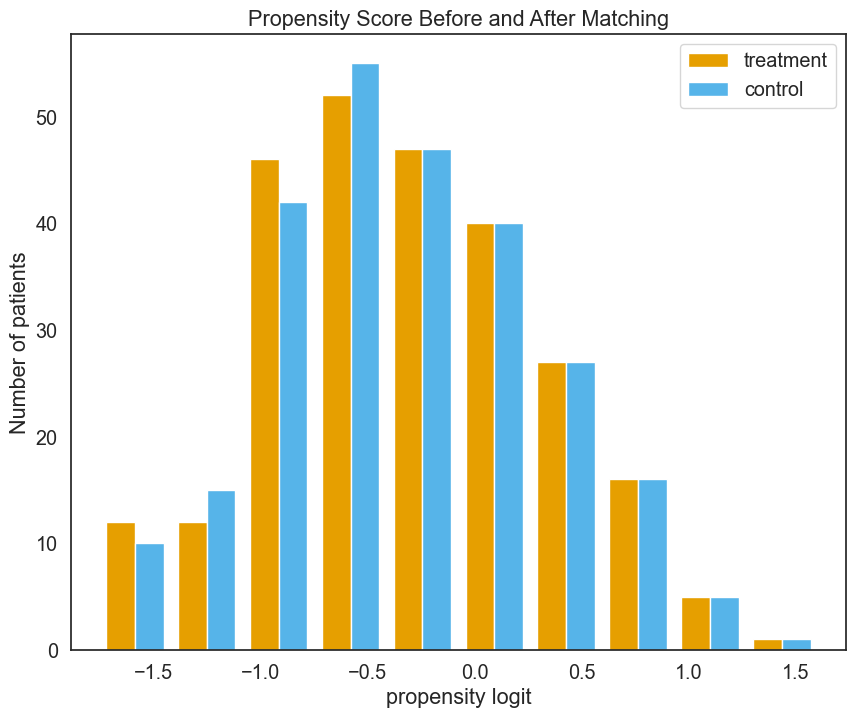

In [124]:
psm.plot_match(Title='Propensity Score Before and After Matching')

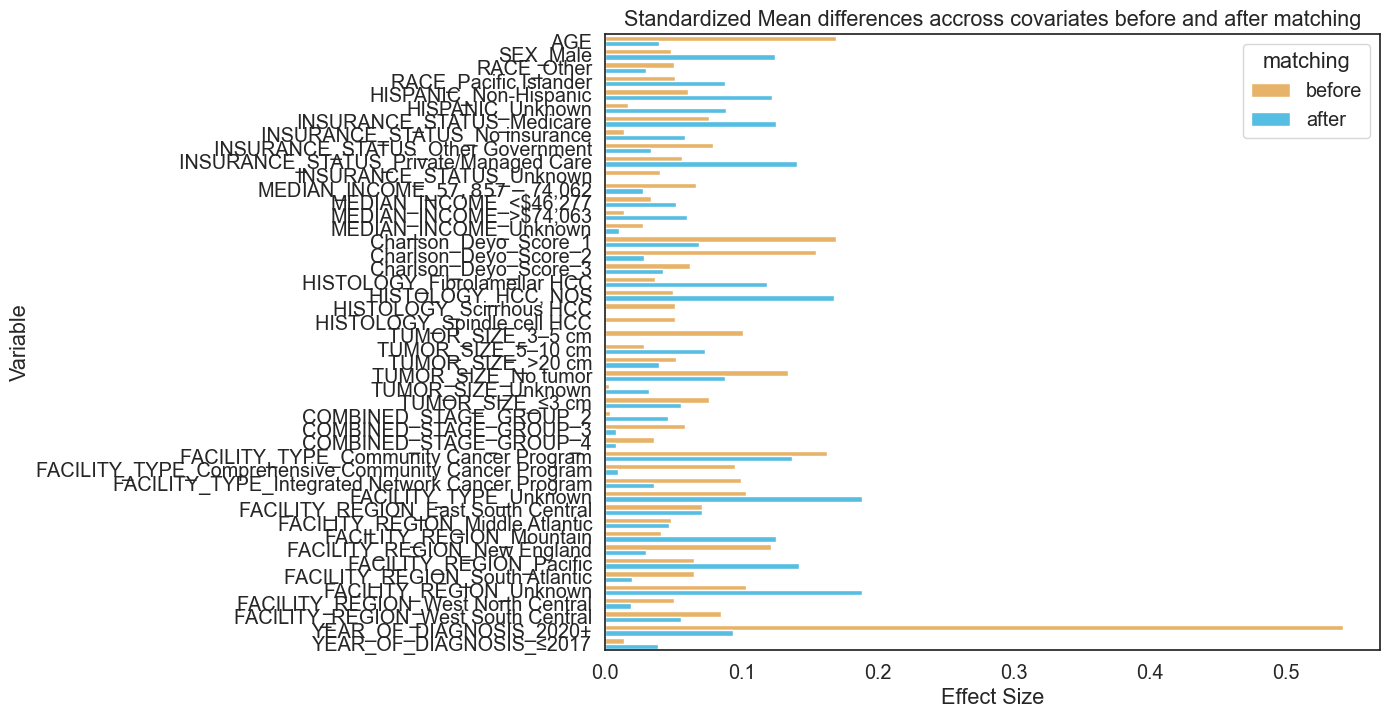

In [125]:
psm.effect_size_plot(title='Standardized Mean differences accross covariates before and after matching', before_color='#FCB754', after_color='#3EC8FB', save=False)


In [126]:
df_matched = psm.df_matched
df_matched

,id,AGE,SEX_Male,RACE_Other,RACE_Pacific Islander,HISPANIC_Non-Hispanic,HISPANIC_Unknown,INSURANCE_STATUS_Medicare,INSURANCE_STATUS_No insurance,INSURANCE_STATUS_Other Government,...,FACILITY_REGION_South Atlantic,FACILITY_REGION_Unknown,FACILITY_REGION_West North Central,FACILITY_REGION_West South Central,YEAR_OF_DIAGNOSIS_2020+,YEAR_OF_DIAGNOSIS_≤2017,propensity_score,propensity_logit,sequence_group,matched_ID
0,3204,75,True,True,False,True,False,True,False,False,...,False,False,False,False,True,False,0.441953,-0.233239,0,213982.0
1,4941,73,True,True,False,True,False,True,False,False,...,False,False,False,False,False,False,0.725998,0.974409,0,198706.0
2,5279,68,True,True,False,True,False,False,False,False,...,False,False,False,False,True,False,0.458426,-0.166683,0,147064.0
3,7512,77,True,True,False,True,False,True,False,False,...,True,False,False,False,True,False,0.337964,-0.672379,0,62255.0
4,7898,66,True,True,False,True,False,True,False,False,...,False,False,False,False,True,False,0.339006,-0.667728,0,132029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,84883,82,True,True,False,False,False,False,False,False,...,False,False,False,False,True,False,0.263507,-1.027820,1,NaN
512,297727,60,True,True,False,True,False,True,False,False,...,False,False,True,False,True,False,0.190791,-1.444878,1,NaN
513,115178,77,True,True,False,True,False,True,False,False,...,False,False,False,False,True,False,0.174691,-1.552739,1,NaN
514,286198,63,True,True,False,True,False,True,False,False,...,False,False,False,False,True,False,0.239821,-1.153664,1,NaN


In [135]:
covariate_groups = {
    'AGE': ['AGE'],  # already numeric
    'SEX': [col for col in df_matched.columns if col.startswith('SEX_')],
    'RACE': [col for col in df_matched.columns if col.startswith('RACE_')],
    'HISPANIC': [col for col in df_matched.columns if col.startswith('HISPANIC_')],
    'INSURANCE_STATUS': [col for col in df_matched.columns if col.startswith('INSURANCE_STATUS_')],
    'MEDIAN_INCOME': [col for col in df_matched.columns if col.startswith('MEDIAN_INCOME_')],
    'Charlson_Deyo_Score': [col for col in df_matched.columns if col.startswith('Charlson_Deyo_Score')],
    'HISTOLOGY': [col for col in df_matched.columns if col.startswith('HISTOLOGY_')],
    'TUMOR_SIZE': [col for col in df_matched.columns if col.startswith('TUMOR_SIZE_')],
    'COMBINED_STAGE_GROUP': [col for col in df_matched.columns if col.startswith('COMBINED_STAGE_GROUP')],
    'FACILITY_TYPE': [col for col in df_matched.columns if col.startswith('FACILITY_TYPE_')],
    'FACILITY_REGION': [col for col in df_matched.columns if col.startswith('FACILITY_REGION_')],
    'YEAR_OF_DIAGNOSIS': [col for col in df_matched.columns if col.startswith('YEAR')]
}

asmd_psm = []

for group_name, col_list in covariate_groups.items():
    d_list = []
    for col in col_list:
        try:
            d = compute_asmd(df_matched, col, 'sequence_group', weight_col=None)
            d_list.append(d)
        except Exception as e:
            print(f"Skipping {col}: {e}")
    asmd_psm.append(max(d_list) if d_list else np.nan)


In [137]:
asmd_df['PSM'] = asmd_psm
asmd_df

,Covariate,Unweighted,IPTW,PSM
0,AGE,0.100715,0.030226,0.039206
1,SEX,0.058545,0.075864,0.125047
2,RACE,0.052607,0.027083,0.088216
3,HISPANIC,0.041222,0.016969,0.122567
4,INSURANCE_STATUS,0.058896,0.039677,0.140748
5,MEDIAN_INCOME,0.046765,0.027137,0.059896
6,Charlson_Deyo_Score,0.105752,0.015458,0.068881
7,HISTOLOGY,0.041918,0.032880,0.168121
8,TUMOR_SIZE,0.082332,0.022864,0.088216
9,COMBINED_STAGE_GROUP,0.047192,0.015886,0.045847


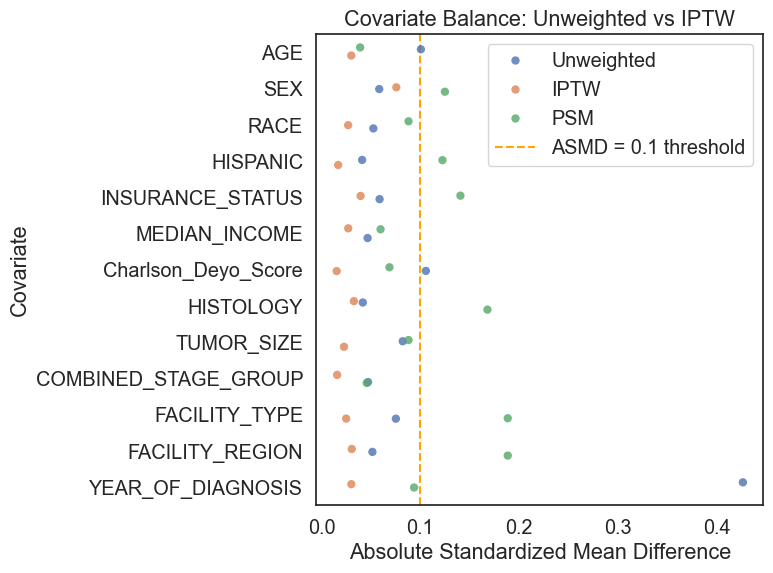

In [138]:
asmd_df_melted = asmd_df.melt(id_vars='Covariate', var_name='Method', value_name='ASMD')

plt.figure(figsize=(8, 6))
sns.stripplot(data=asmd_df_melted, x='ASMD', y='Covariate', hue='Method', jitter=0.15, size=6, alpha=0.8)
plt.axvline(0.1, linestyle='--', color='orange', label='ASMD = 0.1 threshold')
plt.xlabel("Absolute Standardized Mean Difference")
plt.title("Covariate Balance: Unweighted vs IPTW")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()